# What is tweezepy?

A single-molecule force spectrscopy (SMFS) video-tracking instrument, such as a magnetic tweezer (MT) or optical trap (OT), precisely and accurately manipulates molecules by tethering them to a micron-scale bead. An essential part of these SMFS experiments is reliably and accurately calibrating the applied force. 

Typically, calibrating the applied force is accomplished by comparing the probe trajectory to an analytical model derived from the overdamped Langevin equation,

\begin{equation}
\kappa x + \gamma \dot{x} = F_L
\end{equation}

where $\gamma$ is the Stoke's dissipation coefficient and $\kappa$ is the spring constant of the trap, from which the applied force can be determined. $F_L$ is a stochastic force that obeys the fluctuation-dissipation relation, $\langle F_L(t+t')F_L(t)\rangle = 2\gamma k_BT\delta(t')$, where $\delta(t)$ is the Dirac delta function.

The simplest method for determining $\kappa$ is by relating it to the standard variance, $\sigma^2_x$, via the equipartition theorem:

\begin{equation}
\sigma^2_x = \frac{k_BT}{\kappa}.
\end{equation}

However, this can lead to biased $\kappa$ estimates because of 1) the camera exposure time which low-pass filters the bead positions, lowering the variance, and 2) parasitic noise which increases the variance. More robust calibration methods rely on computing and fitting the power spectral density (PSD) or Allan variance (AV) of the bead trajectory, which can separate the thermal motion of the bead from parasitic noise.

With the PSD and AV, several factors need to be taken into account, including: 
1. Spectral distortions. 
2. Camera exposure time. 
3. Biased fitting. 

Tweezepy provides and easy-to-use computational implementation of two robust calibration methods. From a user-provided bead trajectory, it computes either the PSD and AV and fits it to a closed-form expression for thermal noise, using maximum likelihood estimation (MLE), to estimate parameters and their uncertainties.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tweezepy.simulations import simulate_trace, downsampled_trace
from tweezepy.smmcalibration import PSD, AV

# Example data

To simulate a bead trajectory, we can recast the overdamped Langevin equation as an equation of probability flux (Smoluchowski equation), then apply an iterative scheme to generate successive discrete time points of the bead trajectory.
\begin{equation}
\delta x = \frac{\delta t}{\gamma}\left(\sqrt{\frac{2\gamma k_BT}{\delta t}} F_L-\kappa x_{j-1}\right) \\
x_j = x_{j-1}+\delta x
\end{equation}

The discrete time points from the above simulation represents a situation in which the probe motion is exactly as fast as the instrument measurement time, $\tau_s = 1/f_s$. In video-tracking experiments, bead motion occurs on timescales faster than the measurement time - i.e. video tracking introduces a low-pass filter. To capture this low-pass filtering effect, we can simulate the probe position faster than the measurement time, then average groups of points together.

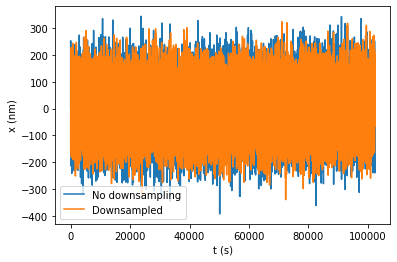

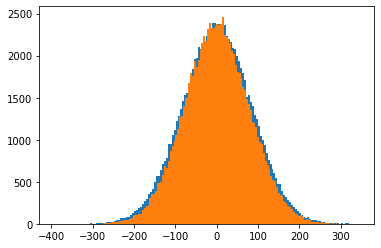

In [5]:
fc = 10 # corner frequency
gamma = 1e-5 # dissipation due to viscous drag, in pN s/nm
             # 1e-5 is a typical value for an MT experiment
kappa = gamma*2*np.pi*fc # kappa in pN/nm
fsample = 400 # sampling frequency in Hz
N  = 102400 # number of points in trajectory
seed = 0 # random seed for reproducibility
# No downsampling
xtrace = simulate_trace(gamma,kappa,fsample,N, seed = seed)
plt.plot(xtrace,label = 'No downsampling')
# With downsampling
xtrace_ds = downsampled_trace(gamma,kappa,fsample,N, seed = seed)
plt.plot(xtrace_ds,label = 'Downsampled')
plt.xlabel('t (s)')
plt.ylabel('x (nm)')
plt.legend()
plt.show()
_ = plt.hist(xtrace,bins = 'auto', label = 'No downsampling')
_ = plt.hist(xtrace_ds, bins = 'auto', label = 'Downsampling')
plt.show()

We can see that the amplitude of the raw simulation points is greater than those of the downsampled points. The averaging low-pass filters the trajectory.

# Basic tweezepy usage

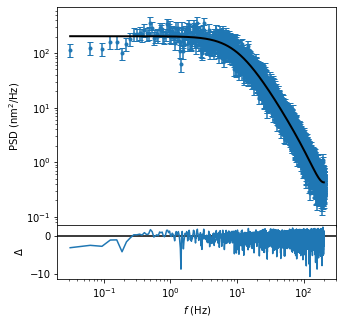

In [6]:
from tweezepy.smmcalibration import PSD,AV
# Computing the power spectral density is as easy as:
psd = PSD(xtrace_ds,fsample, bins = 15) 
# Note I'm splitting the data into 15 bins to help with visualization
# Fitting the power spectral density is as easy as:
psd.mlefit()
# Plotting the fit and residuals is as easy as:
psd.plot()
plt.show()

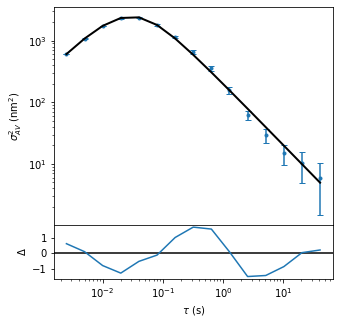

In [7]:
# Similarly, for the AV
# Computing the AV is as easy as:
av = AV(xtrace_ds,fsample)
# Fitting the AV with mle
av.mlefit()
# Plotting the AV
av.plot()
plt.show()

One thing to note is that the AV compresses the data more than the PSD (without loss of information), so it is easier to judge the quality of fit based on the residuals.

In [8]:
# The results of the fit are stored in a dictionary format for convenience
psd.results

{'chi2': 9541.523752905014,
 'redchi2': 1.4915622561990016,
 'g': 9.987274585927754e-06,
 'g_error': 4.939065221213263e-08,
 'k': 0.0006338066057220219,
 'k_error': 7.270886693644723e-06,
 'support': 1.0,
 'p-value': 0.0,
 'AIC': 13644.000903245327}

In [10]:
# The results can also be accessed via various methods
print(psd.params)
print(psd.std_errors)
print(psd.AIC)

[9.98727459e-06 6.33806606e-04]
[4.93906522e-08 7.27088669e-06]
13644.000903245327
